In [1]:
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Przygotowanie transformacji do przekształcenia obrazów

In [2]:
train_images = tv.datasets.ImageFolder('dataSet/train')

# Wizualizacja zdjęcia

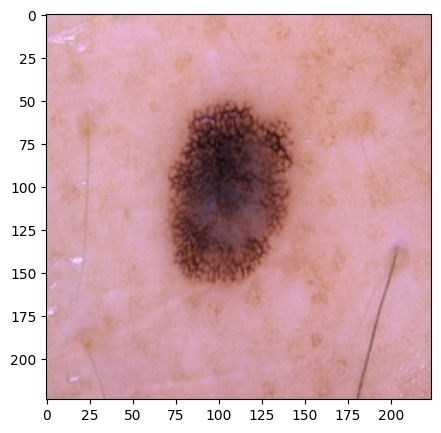

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(train_images[0][0])

In [4]:
labels = [_[1] for _ in train_images]

# Diagram danych treningowych

<BarContainer object of 2 artists>

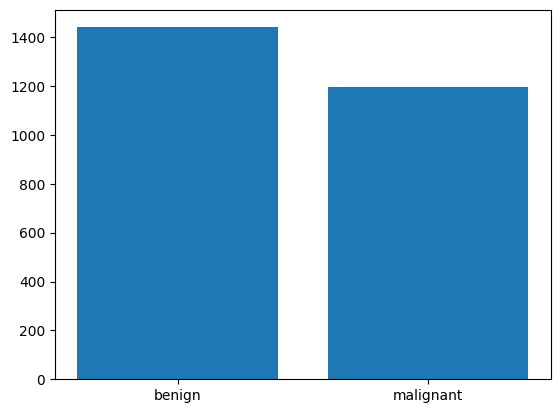

In [5]:
plt.bar(train_images.classes, np.unique(labels, return_counts=True)[1])

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
ds = tv.datasets.ImageFolder('dataSet/train', transform=transform)

In [8]:
dsTest = tv.datasets.ImageFolder('dataSet/test', transform=transform)

In [9]:
for b in ds:
    print(type(b[0]),b[0].shape, b[1])
    break

<class 'torch.Tensor'> torch.Size([3, 224, 224]) 0


In [10]:
img = b[0]

In [11]:
img.min(),img.max()

(tensor(0.0235), tensor(1.))

In [12]:
img = b[0].permute(1,2,0).numpy()
print(type(img), img.shape, img.dtype)

<class 'numpy.ndarray'> (224, 224, 3) float32


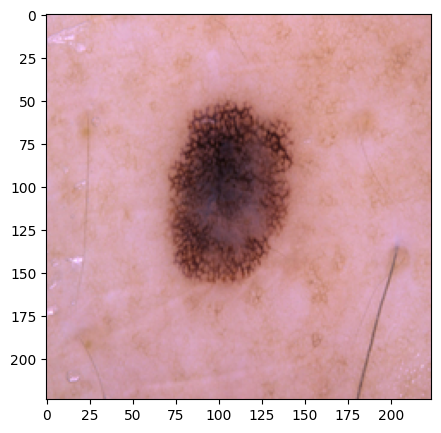

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(img)

In [14]:
from keras import models
from keras import layers

In [15]:
network = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # Zakładamy 2 klasy
])

In [16]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
data_loader = DataLoader(ds, batch_size=32, shuffle=True)

In [18]:
data_loader_test = DataLoader(dsTest, batch_size=32)

In [19]:

def pytorch_to_tf_dataset(loader):
    def generator():
        for images, labels in loader:
            # Konwersja z NCHW na NHWC
            images = images.permute(0, 2, 3, 1).numpy()
            labels = tf.keras.utils.to_categorical(labels, num_classes=2)  # Dostosuj num_classes do ilości klas
            yield images, labels

    return tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, 224, 224, 3), (None, 2))
    ).repeat()  # Powtarzanie danych

train_dataset = pytorch_to_tf_dataset(data_loader)


In [20]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

network.fit(train_dataset, epochs=30, steps_per_epoch=len(ds) // 32, callbacks=[cp_callback])


Epoch 1/30
82/82 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.5347
Epoch 1: saving model to training_1\cp.ckpt
82/82 [==============================] - 109s 1s/step - loss: 1.1413 - accuracy: 0.5347
Epoch 2/30
82/82 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.6948
Epoch 2: saving model to training_1\cp.ckpt
82/82 [==============================] - 106s 1s/step - loss: 0.6074 - accuracy: 0.6948
Epoch 3/30
82/82 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7447
Epoch 3: saving model to training_1\cp.ckpt
82/82 [==============================] - 105s 1s/step - loss: 0.5231 - accuracy: 0.7447
Epoch 4/30
82/82 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.7551
Epoch 4: saving model to training_1\cp.ckpt
82/82 [==============================] - 99s 1s/step - loss: 0.5030 - accuracy: 0.7551
Epoch 5/30
82/82 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.7666
Epo

In [21]:
test_dataset = pytorch_to_tf_dataset(data_loader_test)

In [22]:
# Przykład przygotowania test_dataset
test_ds = tv.datasets.ImageFolder('dataSet/test', transform=transform)  # Ścieżka do danych testowych
test_data_loader = DataLoader(test_ds, batch_size=32, shuffle=False)  # DataLoader dla danych testowych
test_steps = len(test_ds) // 32
test_dataset = pytorch_to_tf_dataset(test_data_loader)  # Konwersja do tf.data.Dataset|

# Ewaluacja modelu na danych testowych
test_loss, test_acc = network.evaluate(test_dataset, steps=test_steps)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


20/20 [==============================] - 10s 468ms/step - loss: 1.1223 - accuracy: 0.8250
Test accuracy: 0.824999988079071, Test loss: 1.1223180294036865


In [23]:
network.save('model/skinCancerModel.keras')

In [24]:
network_json = network.to_json()

with open('model/skinCancerModel.json', 'w') as json_file:
    json_file.write(network_json)
